In [61]:
import reskit as rk
import pandas as pd
import numpy as np

This script illustrates how to run a simulation with ETHOS.RESKit.Wind.

## Preparations
In ETHOS.RESKit.Wind one can simulate each wind turbine individually with its own characteristics.
If you know the turbine model and it is included in RESKit, you can use the actual power curve of the turbines. Otherwise RESKit will create a synthetic power curve for you.
The following specifications need to be given by the user:
- latitude
- longitute
- hub height [m]
- capacity [kW]
- rotor diameter [m] (or power curve)

These specifications are given in the form of a pandas DataFrame.

In [62]:
# Create Placements DataFrame with turbine locations and specifications

placements = pd.DataFrame(
    {
        "lon": [5.985195, 5.994685, 6.004750],
        "lat": [50.797254, 50.794208, 50.784432],
        "hub_height": [120, 120, 82],
        "capacity": [4000, 4000, 4000],
        "rotor_diam": [130, 150, 136],
        "powerCurve": [np.nan, np.nan, "V136-4000-4200_Vestas"]
    }
)
placements

,lon,lat,hub_height,capacity,rotor_diam,powerCurve
0,5.985195,50.797254,120,4000,130,NaN
1,5.994685,50.794208,120,4000,150,NaN
2,6.004750,50.784432,82,4000,136,V136-4000-4200_Vestas


# Define workflow_args (dictionary)
We save the 
- path to the ERA5 data 
- placements DataFrame
- path to the GWA data
- path to esa_cci data

within the workflow_args.

RESKit will simulate the weather year given in the ERA5 path.

Choose a weather_year that is available in the downloaded ERA5 dataset.

RESKit will automatically replace the placeholders <X-TILE>, <Y-TILE>

In [63]:
# Here we will use the test data within the repository. In reality the paths would be different.
#Example:
#weather_year = 2018
#era5_path = r'/path_to_ERA5_data/4/<X-TILE>/<Y-TILE>/<WEATHER-YEAR>'
#era5_path = era5_path.replace('<WEATHER-YEAR>', str(weather_year))
workflow_args = {}
workflow_args["era5_path"] = rk.TEST_DATA["era5-like"]
workflow_args["gwa_100m_path"] = rk.TEST_DATA["gwa100-like.tif"]
workflow_args["esa_cci_path"] = rk.TEST_DATA["ESA_CCI_2018_clip.tif"]
workflow_args["placements"] = placements.copy()

# Run the simulation workflow
RESKit will run the simulation and create an xarray Dataset with the simulation results for you.
Apart from the capacity_factor, RESKit also includes the turbine specifications and intermediate data used to determine the capacity factor (such as wind speeds, surface pressure etc.)

In [64]:
reskit_xr = rk.execute_workflow_iteratively(
    workflow=rk.wind.wind_era5_2023,
    weather_path_varname="era5_path",
    zoom=4,
    **workflow_args,
)
reskit_xr

Now processing tile 1/1 with 3 locations: /fast/home/p-dunkel/Promotion/programms/repos/RESKit_develop/reskit/_test/data/era5-like
Applied correction factors: x=0.7506109812177267, b=0.9064913929439484


/fast/home/p-dunkel/Promotion/programms/repos/RESKit_develop/reskit/workflow_manager.py:352: DeprecationWarning: 'nan' value for 'nodata_fallback' is deprecated and will be removed soon. Use np.nan instead.
  warnings.warn(


<xarray.Dataset>
Dimensions:                         (location: 3, time: 140)
Coordinates:
  * location                        (location) int64 0 1 2
  * time                            (time) datetime64[ns] 2014-12-31T23:30:00...
Data variables: (12/14)
    lon                             (location) float64 5.985 5.995 6.005
    lat                             (location) float64 50.8 50.79 50.78
    hub_height                      (location) int64 120 120 82
    capacity                        (location) int64 4000 4000 4000
    rotor_diam                      (location) int64 130 150 136
    powerCurve                      (location) object 'SPC:301,25' ... 'V136-...
    ...                              ...
    roughness                       (location) float64 0.1 0.03 0.03
    elevated_wind_speed             (time, location) float64 4.399 ... 6.801
    surface_pressure                (time, location) float64 1.013e+05 ... 9....
    surface_air_temperature         (time, location) float64 0.01979 ... 2.357
    boundary_layer_height           (time, location) float64 120.4 ... 346.5
    capacity_factor                 (time, location) float64 0.06468 ... 0.2969

RESKit will output the capacity factor of each location for every hour of the simulated year.

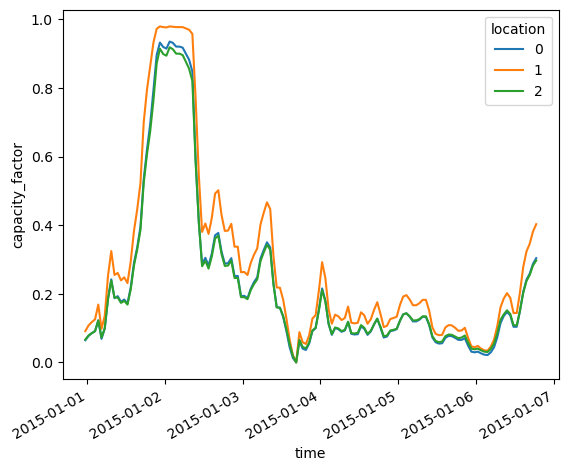

In [65]:
reskit_xr["capacity_factor"].isel(time=slice(0, 400)).plot.line(x="time")